# Projekt w ramach Pracy Magisterskiej
### *Niezależne wyrocznie w sieci Ethereum z wykorzystaniem uczenia maszynowego i dowodu z wiedzą zerową*

**Przeprowadzone kroki**
1. Przygotowanie danych i wytrenowanie sieci neuronowej
2. Konwersja sieci neuronowej w obwód arymetyczny z wykorzystaniem biblioteki EZKL
3. Utworzenie weryfikatora za pomocą języka Solidity i wdrożenie go do testowego środowiska Remix

**Important Note**: Aby zapobiec nieoczekiwanym błędom, zaleca się uruchomić notatnik po pojedynczych komórkach.

## Krok 1: Przygotowanie pierwotnego modelu z wykorzystaniem sieci neuronowej

W ramach badań pracy, zastosowano popularny zbiór danych irysów. Zbiór danych Iris to kolekcja kwiatów irysa i jest jednym z najwcześniej pozyskanych i udokumentowanych zbiorów danych, wykorzystywanych do walidacji, metodologii i klasyfikacji.

[Więcej informacji na temat zbioru danych](https://archive.ics.uci.edu/dataset/53/iris)

Na początku należy wczytać niezbędne biblioteki

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import json
import ezkl

## Opis zbioru danych

In [2]:
df1 = pd.read_csv('Iris.csv')

In [3]:
def get_info_dataframe(dataframe):
    print(f"Opis zbioru danych - \n")
    print(dataframe.info(),"\n")
    print(f"Wartości brakujące - \n")
    print(dataframe.isnull().sum(),"\n")
    print(f"Wymiar zbioru danych - \n")
    print(dataframe.shape)

In [4]:
get_info_dataframe(df1)

Opis zbioru danych - 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None 

Wartości brakujące - 

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64 

Wymiar zbioru danych - 

(150, 6)


Zmiana etykiet z ciągów znaków na wartości numeryczne, które są łatwiejsze do zrozumienia przez algorytm.

In [5]:
df1['Species'] = df1['Species'].map({'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2})
df1.drop(['Id'],axis=1,inplace=True)

In [6]:
df1.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
X = df1.drop(["Species"],axis=1).values
y = df1["Species"].values

In [8]:
scaler = StandardScaler()

Podział zbioru danych na dane treningowe i dane testowe.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Model sieci neuronowej

In [12]:
class NeuralNetworkClassificationModel(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(NeuralNetworkClassificationModel,self).__init__()
        self.input_layer    = nn.Linear(input_dim,128)
        self.hidden_layer1  = nn.Linear(128,64)
        self.output_layer   = nn.Linear(64,output_dim)
        self.relu = nn.ReLU()


    def forward(self,x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.output_layer(out)
        return out

In [13]:
input_dim  = 4 # 4 neurony dla warstwy wejściowej: sepal_length, sepal_width, petal_length, petal_width
output_dim = 3 # 3 neurony dla warstwy wyjściowej: setosa, versicolor, virginica
model = NeuralNetworkClassificationModel(input_dim,output_dim)

## Proces nauczania z wykorzystaniem odpowiednich parametrów

In [14]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        # oczyszczanie gradientu
        optimizer.zero_grad()

        # operacja forward feed
        output_train = model(X_train)

        # obliczenie funkcji straty
        loss_train = criterion(output_train, y_train)

        # propagacja wsteczna
        loss_train.backward()

        # aktualizacja parametrów
        optimizer.step()


        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoka {epoch+1}/{num_epochs}, Strata (zbiór treningowy): {loss_train.item():.4f}, Strata (zbiór testowy): {loss_test.item():.4f}")

In [16]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [17]:
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoka 50/1000, Strata (zbiór treningowy): 0.0273, Strata (zbiór testowy): 0.0030
Epoka 100/1000, Strata (zbiór treningowy): 0.0023, Strata (zbiór testowy): 0.0023
Epoka 150/1000, Strata (zbiór treningowy): 0.0005, Strata (zbiór testowy): 0.0025
Epoka 200/1000, Strata (zbiór treningowy): 0.0002, Strata (zbiór testowy): 0.0028
Epoka 250/1000, Strata (zbiór treningowy): 0.0001, Strata (zbiór testowy): 0.0030
Epoka 300/1000, Strata (zbiór treningowy): 0.0001, Strata (zbiór testowy): 0.0032
Epoka 350/1000, Strata (zbiór treningowy): 0.0001, Strata (zbiór testowy): 0.0033
Epoka 400/1000, Strata (zbiór treningowy): 0.0001, Strata (zbiór testowy): 0.0032
Epoka 450/1000, Strata (zbiór treningowy): 0.0000, Strata (zbiór testowy): 0.0032
Epoka 500/1000, Strata (zbiór treningowy): 0.0000, Strata (zbiór testowy): 0.0032
Epoka 550/1000, Strata (zbiór treningowy): 0.0000, Strata (zbiór testowy): 0.0032
Epoka 600/1000, Strata (zbiór treningowy): 0.0000, Strata (zbiór testowy): 0.0032
Epoka 650/1000, S

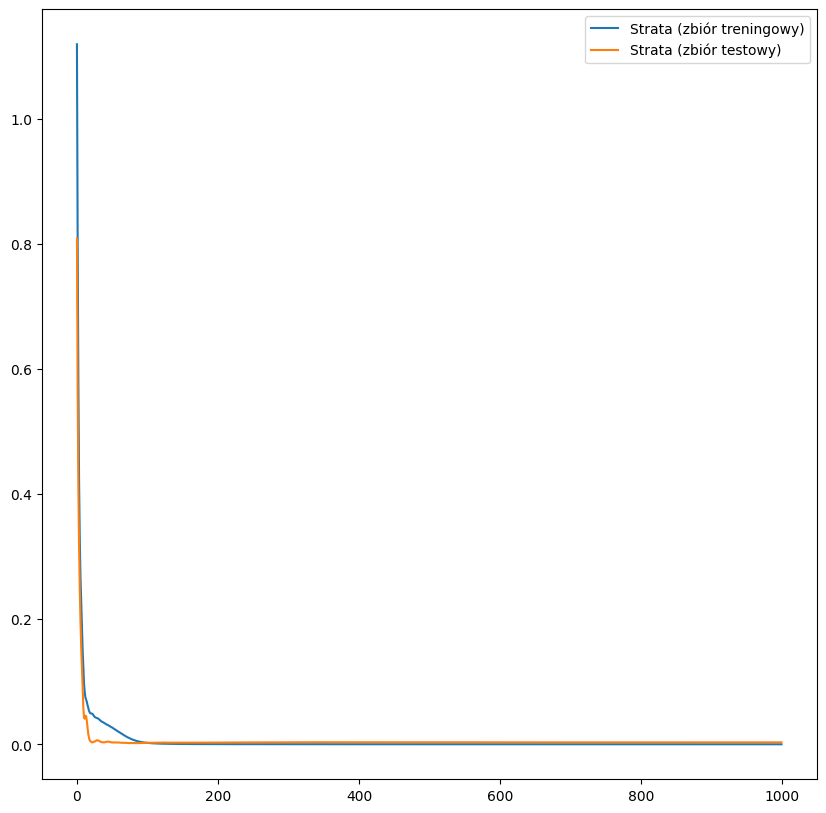

In [18]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Strata (zbiór treningowy)')
plt.plot(test_losses, label='Strata (zbiór testowy)')
plt.legend()
plt.show()

In [19]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

In [20]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []

    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0

    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [21]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)

In [22]:
print(f"Precyzja modelu dla danych zbioru treningowego: {round(train_acc*100,3)}%")
print(f"Precyzja modelu dla danych zbioru testowego: {round(test_acc*100,3)}%")

Precyzja modelu dla danych zbioru treningowego: 100.0%
Precyzja modelu dla danych zbioru testowego: 100.0%


# Krok 2: Konwersja modelu na obwód arytmetyczny

Na początku eksportujemy model jako uniwersalny plik `.onnx`. Biblioteka EZKL wczyta ten plik i dokona konwersji. Po przeprowadzonej konwersji w obwód, będzie można wygenerować dowód obliczeniowy dla modelu.

In [23]:
# Określenie ścieżek

model_path = os.path.join('network.onnx')
data_path = os.path.join('input.json')
cal_data_path = os.path.join('calibration.json')

Po procesie treningowym, następuje eksport pliku (`network.onnx`). Tworzymy także przykładowy plik z danymi wejściowymi (`input.json`).

In [24]:
# Przykładowy kwiat (Virginica) - nasz input.json
# x = torch.tensor([[7.7000, 2.6000, 6.9000, 2.3000]])
x = X_test[0].reshape(1, 4)

# Zmienia tryb modelu na ewaluację
model.eval()

# Dla gotowego modelu wprowadzamy dane wejściowe i oczekujemy klasyfikacji.

with torch.no_grad():
        output = model(x)

# Proces eksportowania
torch.onnx.export(model,                     # nasz model
                  x,                         # dane wejściowe dla modelu
                  model_path,                # ścieżka zapisu dla modelu
                  export_params=True,        # eksport parametrów do modelu docelowego
                  opset_version=10,          # wersja ONNX
                  do_constant_folding=True,  # włączamy optymalizacje constant folding
                  input_names = ['input'],   # nazwa dla danych wejściowych
                  output_names = ['output'], # nazwa dla danych wyjściowych
                  dynamic_axes={'input' : {0 : 'batch_size'},    # długość osi dla zmiennych
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Zapis danych wejściowych do input.json
json.dump(data, open(data_path, 'w'))

x

tensor([[ 0.3101, -0.4958,  0.4840, -0.0514]])

In [25]:
species = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
class_likelihood = np.argmax(species)
print(f"Według prywatnego modelu ze zbioru danych, kwiat zaproponowany przez weryfikatora to: { species[class_likelihood] }")

Według prywatnego modelu ze zbioru danych, kwiat zaproponowany przez weryfikatora to: Iris-virginica


Po wyeksportowaniu modelu, możemy przystąpić do wygenerowania ustawień dla fazy konfiguracyjnej

In [26]:
# !RUST_LOG=trace
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "private"

res = ezkl.gen_settings()
assert res == True

Dodatkowa kalibracja w celu optymalizacji zasobów

In [27]:
# wykorzystujemy dane z zestawu testowego do kalibracji
cal_data = dict(input_data = X_test.flatten().tolist())

# Zapis ustawień do calibration.json
json.dump(data, open(cal_data_path, 'w'))

# Optymalizacja, parametry pozostawione domyślnie
res = await ezkl.calibrate_settings(target = "resources", max_logrows = 12, scales = [2])



 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.1489846  | -0.40205097  | 0.7822294 | -0.40205097 | 0.41701856     | 0.40205097       | 0.7822294     | 0.06677532    | 0.25932893         | -0.3389686         | 0.3389686              |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+--------

Następnie proces kompilacji. Pozwala on na szybszą generację dowodu.

In [28]:
res = ezkl.compile_circuit()
assert res == True

Zanim przystąpimy do uruchomienia konfiguracji. Należy wygenerować łańcuch znaków SRS.

In [29]:
res = await ezkl.get_srs()

Uruchomienie konfiguracji pozwoli na wygenerowanie pary kluczy - **klucza dowodzącego** (pk) oraz **klucza weryfikującego** (vk).

In [30]:
res = ezkl.setup()

assert res == True

Następuje proces generowania dowodu dokonania obliczeń na modelu

In [31]:
witness_path = os.path.join('witness.json')

res = await ezkl.gen_witness()
assert os.path.isfile(witness_path)

In [32]:
proof_path = os.path.join('proof.json')

proof = ezkl.prove(proof_type="single", proof_path=proof_path)
assert os.path.isfile(proof_path)

In [33]:
res = ezkl.verify()

assert res == True
print("Weryfikacja dowodu powiodła się.")

Weryfikacja dowodu powiodła się.


### W ten sposób nasza wytrenowana sieć neuronowa została przekonwertowana w obwód arytmetyczny klasy Halo2

# Krok 3: Utworzenie weryfikatora

Mając przygotowany zestaw konfiguracyjny dla obwodu, możemy wdrożyć weryfikatora na łańcuch bloków

Weryfikator napisany jest w języku Solidity, będziemy zatem potrzebować `solc=0.8.20` do tego zadania

Gdy solc (Kompilator Solidity) znajduje się w środowisku, można przystąpić do stworzenia weryfikatora.

In [34]:
sol_code_path = os.path.join('Verifier.sol')
abi_path = os.path.join('Verifier.abi')

res = await ezkl.create_evm_verifier(
        sol_code_path=sol_code_path,
        abi_path=abi_path, 
    )

assert res == True
assert os.path.isfile(sol_code_path)

In [35]:
onchain_input_array = []

# generowanie danych wejściowych dla kontraktu
formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += '"' + str(onchain_input_array[-1]) + '"'
        if j != len(value) - 1:
            formatted_output += ", "
    if i != len(proof["instances"]) - 1:
        formatted_output += ", "
formatted_output += "]"

# Te dane zostaną wykorzystane, aby zweryfikować czy dowód jest prawidłowy. Dane zostaną wprowadzone do wygenerowanego inteligentnego kontraktu Verifier.sol
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  ["0x30644e72e131a029b85045b68181585d2833e84879b9709143e1f593effff59a", "0x0000000000000000000000000000000000000000000000000000000000000b38", "0x30644e72e131a029b85045b68181585d2833e84879b9709143e1f593effffe6b"]
proof:  0x094a9b5ced723b752371f24fe4710d880827f2673001e2984db53380ac77641d0f1241af4a0702acb0b18ae60d3b9c3268da50821dad01329bc051abf6c796e00cf1f8f5f0c26ff725aea188c3fa2f0d5c9afd0b923830b72e629ad4752b58190ec3612c161366f8b3f25ff64884172c9d691eb236c7c3fc4b3a373a696840d924c21e76fb87296343bbac1f4efd53f4ccf8a2742cc8d5d55e7e553bd39bd15a05a0843ea41a9269f5c59b8d6c71cfeb27048ab3f50015bbc7c00971acc1992417381325a72ea342a7048db35bb104441f67e9ce8a2a4d8f1113e66a6c6c6095069e2c0993c8749c7cdd64439804a8d8b9cec2d25b16b02fe35b38b98e4ad31a09a0aec8a8cc9f4df66981e13014583b21878c12288ff4f545d3ccb0669c994400ef0f004644f558f470eda141d4ad32da158673c2e91660b341e0da3a90561e05bf6e9dc84bf03a12cf8843d196cc34e7cdb34c3b68e83472774c0f39cbe7ee2b37262b54d6e800df1974648c20758628f7c5cd90344421aa938960d7d54aa

## Pozostało wdrożyć kontrakt i sprawdzić jak zweryfikuje powyższe wartości.

W ramach badań nad tą pracą, wykorzystano środowisko Remix https://remix.ethereum.org

### Autor: *Pomianowski Jędrzej*
#### Dla Uniwersytetu Ekonomicznego w Poznaniu